## Exploratory Data Analysis: E-commerce Fraud Data

### 1. Setup & Data Loading

In [2]:
import sys
sys.path.append("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# Load processed data (with country)
data_path = Path("../data/processed")
df = pd.read_csv(data_path / "fraud_data_with_country.csv", parse_dates=["signup_time", "purchase_time"])
print("Data shape:", df.shape)
df.head()

Data shape: (151112, 13)


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,ip_int,country
0,62421,2015-02-16 00:17:05,2015-03-08 10:00:39,46,ZCLZTAJPCRAQX,Direct,Safari,M,36,52093.496895,0,52093,NaN
1,173212,2015-03-08 04:03:22,2015-03-20 17:23:45,33,YFGYOALADBHLT,Ads,IE,F,30,93447.138961,0,93447,NaN
2,242286,2015-05-17 16:45:54,2015-05-26 08:54:34,33,QZNVQTUITFTHH,Direct,FireFox,F,32,105818.501505,0,105818,NaN
3,370003,2015-03-03 19:58:39,2015-05-28 21:09:13,33,PIBUQMBIELMMG,Ads,IE,M,40,117566.664867,0,117566,NaN
4,119824,2015-03-20 00:31:27,2015-04-05 07:31:46,55,WFIIFCPIOGMHT,Ads,Safari,M,38,131423.789042,0,131423,NaN


### 2. Dataset Overview

In [4]:
print("=== Basic Info ===")
df.info()

print("\n=== Missing Values ===")
missing = df.isnull().sum()
print(missing[missing > 0])

print("\n=== Duplicate Rows ===")
print("Duplicates:", df.duplicated().sum())

=== Basic Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   user_id         151112 non-null  int64         
 1   signup_time     151112 non-null  datetime64[ns]
 2   purchase_time   151112 non-null  datetime64[ns]
 3   purchase_value  151112 non-null  int64         
 4   device_id       151112 non-null  object        
 5   source          151112 non-null  object        
 6   browser         151112 non-null  object        
 7   sex             151112 non-null  object        
 8   age             151112 non-null  int64         
 9   ip_address      151112 non-null  float64       
 10  class           151112 non-null  int64         
 11  ip_int          151112 non-null  int64         
 12  country         129146 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(5), object(5)
memory usage: 15

### 3. Class Distribution (Target Imbalance)

Fraud (1) vs Non-Fraud (0):
class
0    136961
1     14151
Name: count, dtype: int64

Fraud rate: 9.3646%


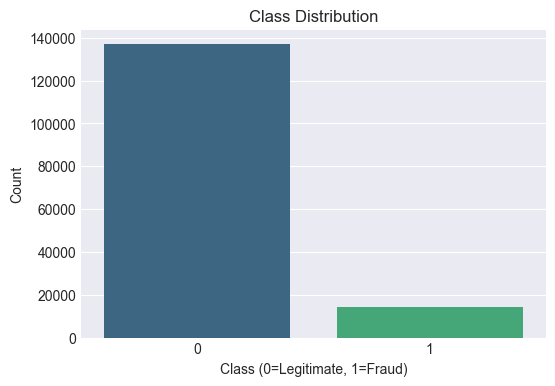

In [5]:
target_counts = df['class'].value_counts()
print("Fraud (1) vs Non-Fraud (0):")
print(target_counts)
print(f"\nFraud rate: {target_counts[1] / len(df):.4%}")

plt.figure(figsize=(6,4))
sns.barplot(x=target_counts.index, y=target_counts.values, palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Class (0=Legitimate, 1=Fraud)')
plt.ylabel('Count')
plt.show()

### 4. Univariate Analysis

#### Numeric Features

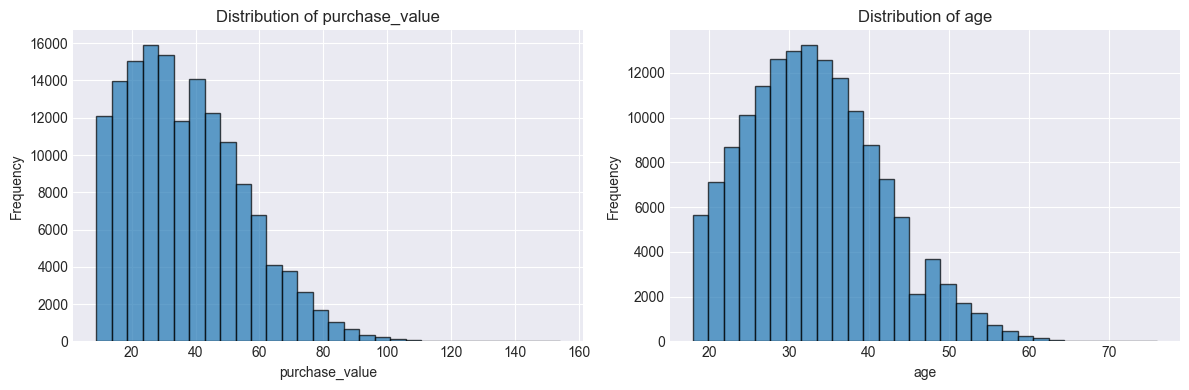

       purchase_value            age
count   151112.000000  151112.000000
mean        36.935372      33.140704
std         18.322762       8.617733
min          9.000000      18.000000
25%         22.000000      27.000000
50%         35.000000      33.000000
75%         49.000000      39.000000
max        154.000000      76.000000


In [6]:
numeric_cols = ['purchase_value', 'age']
fig, axes = plt.subplots(1, 2, figsize=(12,4))
for i, col in enumerate(numeric_cols):
    axes[i].hist(df[col], bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

print(df[numeric_cols].describe())

#### Categorical Features


--- SOURCE ---
source
SEO       60615
Ads       59881
Direct    30616
Name: count, dtype: int64


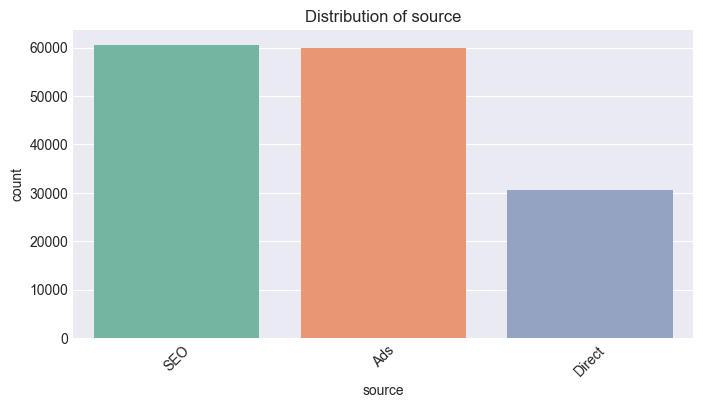


--- BROWSER ---
browser
Chrome     61432
IE         36727
Safari     24667
FireFox    24610
Opera       3676
Name: count, dtype: int64


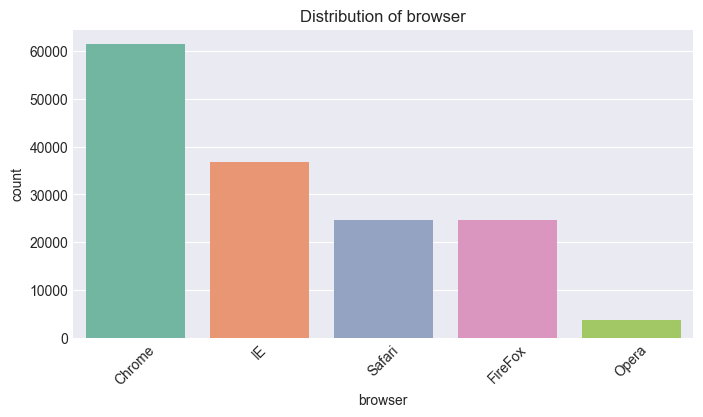


--- SEX ---
sex
M    88293
F    62819
Name: count, dtype: int64


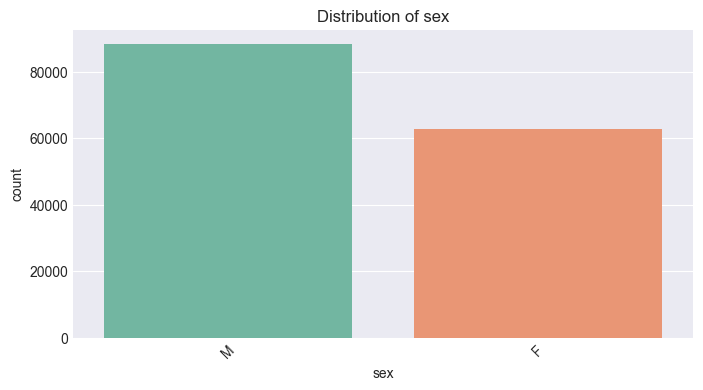

In [7]:
cat_cols = ['source', 'browser', 'sex']
for col in cat_cols:
    print(f"\n--- {col.upper()} ---")
    print(df[col].value_counts())
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()

### 5. Bivariate Analysis with Target

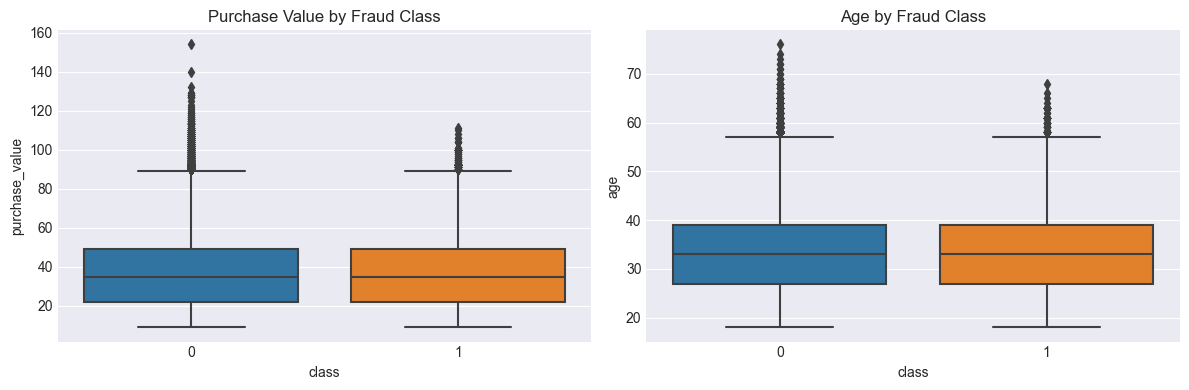

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.boxplot(data=df, x='class', y='purchase_value', ax=axes[0])
axes[0].set_title('Purchase Value by Fraud Class')
sns.boxplot(data=df, x='class', y='age', ax=axes[1])
axes[1].set_title('Age by Fraud Class')
plt.tight_layout()
plt.show()

#### Categorical Vs fraud rate


Fraud rate by source:
source
Direct    0.105370
Ads       0.092066
SEO       0.089285
Name: class, dtype: float64


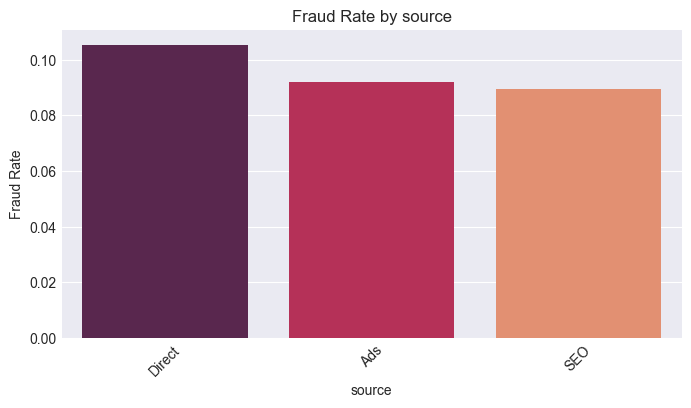


Fraud rate by browser:
browser
Chrome     0.098792
FireFox    0.095165
Safari     0.090201
Opera      0.089227
IE         0.086775
Name: class, dtype: float64


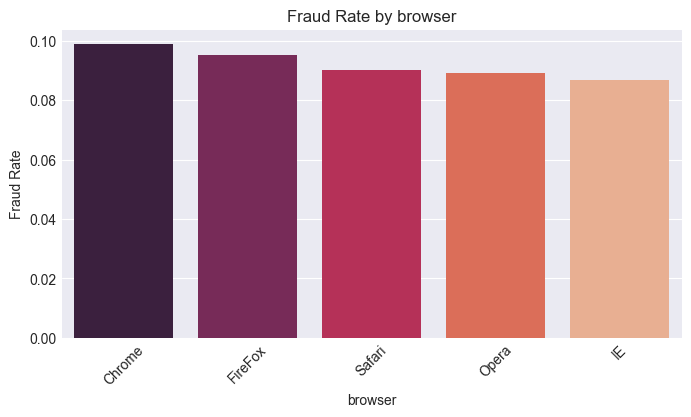


Fraud rate by sex:
sex
M    0.095523
F    0.091007
Name: class, dtype: float64


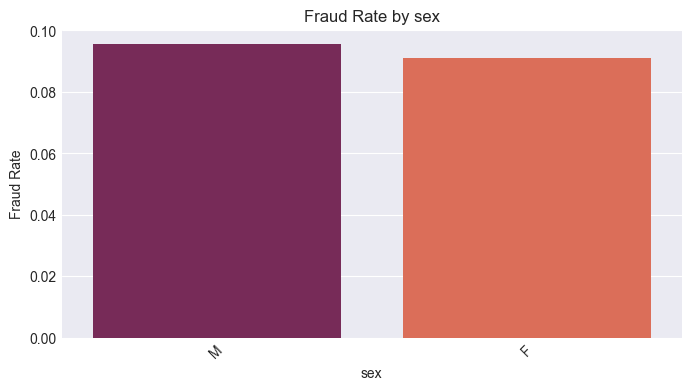

In [9]:
for col in cat_cols:
    fraud_rate = df.groupby(col)['class'].mean().sort_values(ascending=False)
    print(f"\nFraud rate by {col}:")
    print(fraud_rate)
    plt.figure(figsize=(8,4))
    sns.barplot(x=fraud_rate.index, y=fraud_rate.values, palette='rocket')
    plt.title(f'Fraud Rate by {col}')
    plt.ylabel('Fraud Rate')
    plt.xticks(rotation=45)
    plt.show()

Top 10 countries by fraud rate:
country
Turkmenistan             1.000000
Namibia                  0.434783
Sri Lanka                0.419355
Luxembourg               0.388889
Virgin Islands (U.S.)    0.333333
Ecuador                  0.264151
Tunisia                  0.262712
Peru                     0.260504
Bolivia                  0.245283
Kuwait                   0.233333
Name: class, dtype: float64


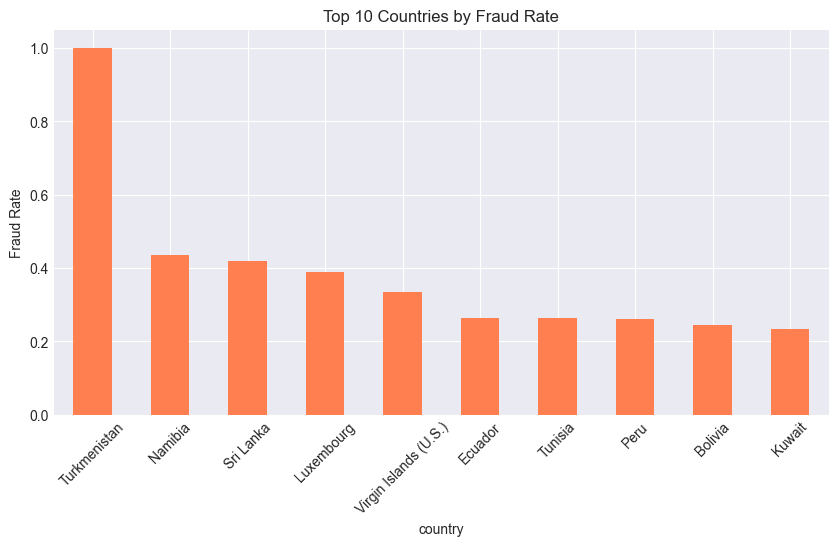

In [10]:
country_fraud = df.groupby('country')['class'].mean().sort_values(ascending=False)
print("Top 10 countries by fraud rate:")
print(country_fraud.head(10))

plt.figure(figsize=(10,5))
country_fraud.head(10).plot(kind='bar', color='coral')
plt.title('Top 10 Countries by Fraud Rate')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45)
plt.show()

### 6. Time-based Patterns

In [11]:
df['purchase_hour'] = df['purchase_time'].dt.hour
df['purchase_dayofweek'] = df['purchase_time'].dt.dayofweek  # Monday=0
df['time_since_signup_hours'] = (df['purchase_time'] - df['signup_time']).dt.total_seconds() / 3600

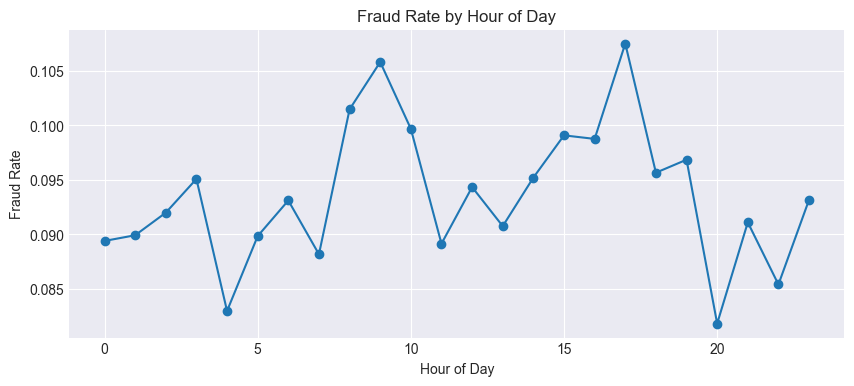

In [12]:
hour_fraud = df.groupby('purchase_hour')['class'].mean()
plt.figure(figsize=(10,4))
hour_fraud.plot(marker='o')
plt.title('Fraud Rate by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate')
plt.grid(True)
plt.show()

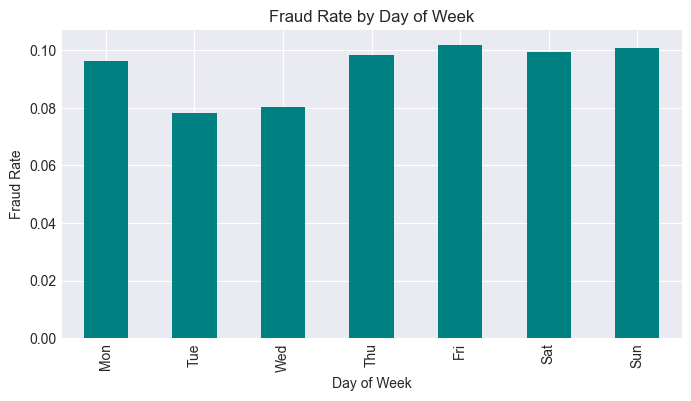

In [13]:
day_map = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
day_fraud = df.groupby('purchase_dayofweek')['class'].mean().rename(index=day_map)
plt.figure(figsize=(8,4))
day_fraud.plot(kind='bar', color='teal')
plt.title('Fraud Rate by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Fraud Rate')
plt.show()

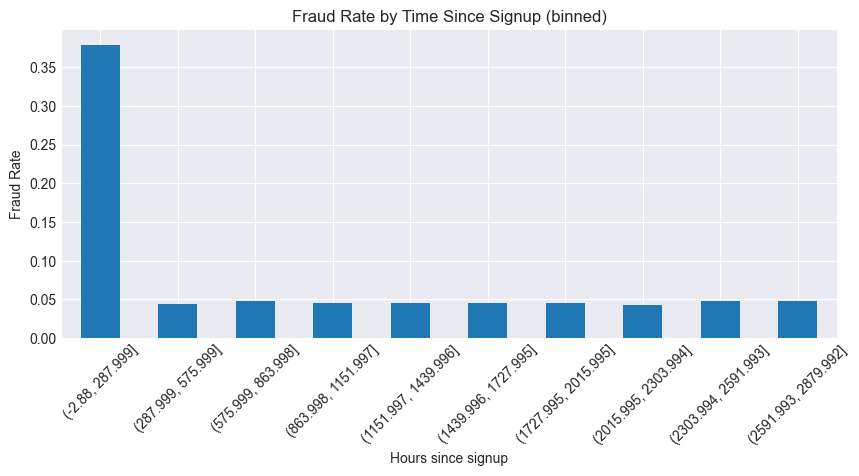

In [14]:
# Bin time since signup
df['time_since_signup_bin'] = pd.cut(df['time_since_signup_hours'], bins=10)
time_fraud = df.groupby('time_since_signup_bin')['class'].mean()
plt.figure(figsize=(10,4))
time_fraud.plot(kind='bar')
plt.title('Fraud Rate by Time Since Signup (binned)')
plt.xlabel('Hours since signup')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45)
plt.show()